<h1 style="font-size: 36px; font-weight: bold">Ứng dụng: Phân loại rau củ quả</h1>

<h1>Nội dung</h1>

Tập dữ liệu bao gồm hình ảnh của các loại thực phẩm sau:

- **Quả**: banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango
- **Rau củ**: cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant

Tập dữ liệu bao gồm ba thư mục:

- train (100 hình ảnh mỗi loại)
- test (10 hình ảnh mỗi loại)
- validation (10 hình ảnh mỗi loại)
Mỗi thư mục trên chứa các thư mục con cho từng loại trái cây và rau củ, trong đó các hình ảnh của từng loại thực phẩm tương ứng được lưu trữ


#### 1. Chuẩn bị và tiền xử lý dữ liệu<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [ ]:
# numpy và pandas để xử lý dữ liệu số và dữ liệu bảng
import numpy as np
import pandas as pd
# path để làm việc với đường dẫn thư mục một cách dễ dàng
from pathlib import Path
# os.path để xử lý các thao tác liên quan đến đường dẫn hệ thống
import os.path
# matplotlib.pyplot để vẽ đồ thị và hình ảnh
import matplotlib.pyplot as plt
# tensorflow để xây dựng và huấn luyện mô hình máy học
import tensorflow as tf
# warnings để bỏ qua các cảnh báo không cần thiết để làm sạch đầu ra
import warnings
warnings.filterwarnings("ignore")

# Định nghĩa các thư mục chứa dữ liệu huấn luyện (train), kiểm tra (test) và xác thực (validation)
# Sử dụng glob để tìm tất cả các tệp .jpg trong các thư mục này và lưu danh sách đường dẫn vào các biến tương ứng
train_dir = Path('train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

# Hàm proc_img trích xuất nhãn từ tên thư mục chứa ảnh
def proc_img(filepath):

    labels = [os.path.split(os.path.dirname(filepath[i]))[-1] \
              for i in range(len(filepath))]

    # Tạo một DataFrame với hai cột 'Filepath' và 'Label'
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    # Trộn ngẫu nhiên hàng để đảm bảo dữ liệu được phân phối ngẫu nhiên
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# Áp dụng hàm proc_img cho tập huấn luyện, kiểm tra và xác thực để tạo các DataFrame tương ứng
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [ ]:
print('-- Training set --\n')
# In ra số lượng hình ảnh trong tập huấn luyện
print(f'Number of pictures: {train_df.shape[0]}\n')
# In ra số lượng nhãn khác nhau và danh sách các nhãn đó
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['bell pepper' 'carrot' 'capsicum' 'lemon' 'ginger' 'chilli pepper'
 'mango' 'cabbage' 'paprika' 'corn' 'turnip' 'peas' 'tomato' 'sweetpotato'
 'kiwi' 'grapes' 'pear' 'garlic' 'sweetcorn' 'cucumber' 'banana'
 'pineapple' 'soy beans' 'orange' 'watermelon' 'potato' 'spinach' 'onion'
 'eggplant' 'pomegranate' 'jalepeno' 'raddish' 'beetroot' 'lettuce'
 'apple' 'cauliflower']


In [ ]:
# Hiển thị 5 dòng đầu tiên của DataFrame tập huấn luyện để kiểm tra dữ liệu
train_df.head(5)

Filepath        Label
0  train\bell pepper\Image_82.jpg  bell pepper
1       train\carrot\Image_23.jpg       carrot
2     train\capsicum\Image_92.jpg     capsicum
3        train\lemon\Image_21.jpg        lemon
4       train\ginger\Image_26.jpg       ginger

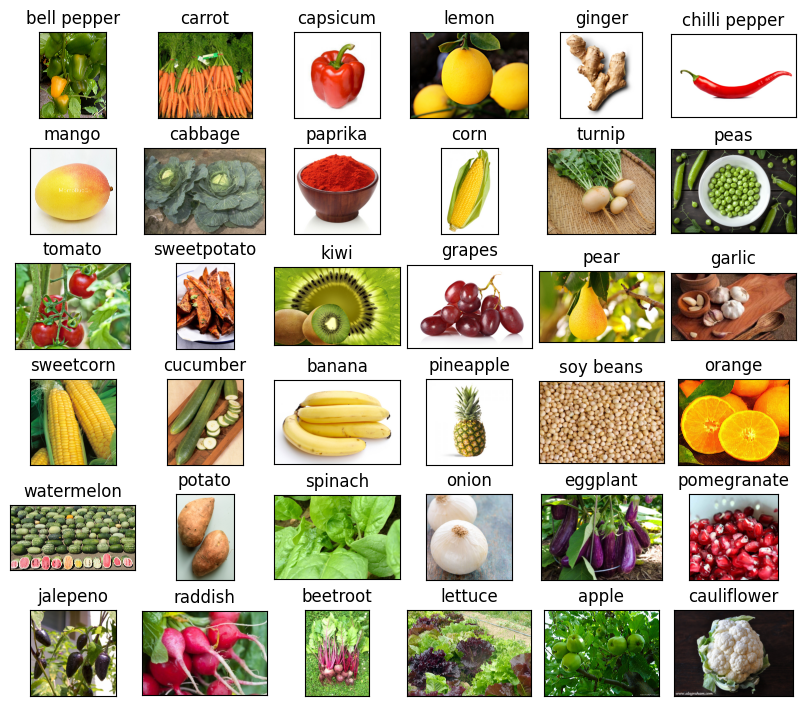

In [ ]:
# Tạo một bản sao của train_df và loại bỏ các dòng trùng lặp dựa trên cột Label để lấy một hình ảnh đại diện cho mỗi loại thực phẩm
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Tạo một lưới 6x6 để hiển thị các hình ảnh và nhãn tương ứng
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

# Đọc và hiển thị hình ảnh từ đường dẫn, đặt tiêu đề là nhãn của hình ảnh đó
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

#### 2. Tải hình ảnh bằng generator và thực hiện Data Augmentation<a class="anchor" id="2"></a>

In [ ]:
# ImageDataGenerator để tạo các trình tạo dữ liệu cho tập huấn luyện và kiểm tra với các thao tác tiền xử lý và tăng cường dữ liệu
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # Sử dụng chức năng tiền xử lý của MobileNetV2 để chuẩn hóa dữ liệu đầu vào
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    # dataframe: Dữ liệu đầu vào từ DataFrame đã chuẩn bị (train_df, val_df, test_df)
    dataframe=train_df,
    # x_col và y_col: Cột chứa đường dẫn ảnh và nhãn tương ứng
    x_col='Filepath',
    y_col='Label',
    # target_size: Kích thước ảnh đầu vào cho mô hình (224x224)
    target_size=(224, 224),
    # color_mode: Chế độ màu RGB
    color_mode='rgb',
    # class_mode: Mô hình phân loại đa lớp với one-hot encoding (categorical)
    class_mode='categorical',
    # batch_size: Kích thước batch là 32
    batch_size=32,
    # shuffle: Trộn dữ liệu cho tập huấn luyện và xác thực
    shuffle=True,
    # seed: Đặt hạt giống ngẫu nhiên để đảm bao tính tái lặp
    seed=0,
    # Thao tác tăng cường dữ liệu: rotation_range, zoom_range, width_shift_range, height_shift_range, shear_range, horizontal_shift, fill_mode để tạo ra các biến thể của hình ảnh nhằm cải thiện độ tổng quát của mô hình
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2855 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.


In [ ]:
# Sử dụng mô hình MobileNetV2 tiền huấn luyện trên tập dữ liệu ImageNet
pretrained_model = tf.keras.applications.MobileNetV2(
    # input_shape: Kích thước đầu vào là 224x224 với 3 kênh màu RGB
    input_shape=(224, 224, 3),
    # Loại bỏ phần đầu tiên (top layers) của mô hình để tùy chỉnh cho bài toán cụ thể
    include_top=False,
    # Sử dụng trọng số đã được huấn luyện trên ImageNet
    weights='imagenet',
    # Sử dụng pooling trung bình toàn cục để trích xuất đặc trưng từ các đặc trưng không gian
    pooling='avg'
)
# Đóng băng các lớp của mô hình tiền huấn luyện để không cập nhật trọng số trong quá trình huấn luyện
pretrained_model.trainable = False

#### 3. Huấn luyện mô hình<a class="anchor" id="3"></a>

In [ ]:
inputs = pretrained_model.input

# Thêm hai lớp Dense với 128 neuron và hàm kích hoạt ReLU để học các đặc trưng phi tuyến từ đầu ra của MobileNetV2
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Lớp Dense cuối cùng với 36 neuron (giả sử có 36 loại thực phẩm) và hàm kích hoạt Softmax để phân loại đa lớp
outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

# Định nghĩa mô hình kết nối đầu vào và đầu ra
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Cấu hình quá trình huấn luyện mô hình
model.compile(
    # Sử dụng trình tối ưu Adam
    optimizer='adam',
    # Hàm mất mát phù hợp cho bài toán phân loại đa lớp
    loss='categorical_crossentropy',
    # Theo dõi độ chính xác trong quá trình huấn luyện
    metrics=['accuracy']
)

# Huấn luyện mô hình với các tham số sau
history = model.fit(
    # Trình tạo dữ liệu huấn luyện với data augmentation
    train_images,
    # Trình tạo dữ liệu xác thực
    validation_data=val_images,
    # Kích thước batch là 32
    batch_size = 32,
    # Số lần lặp qua toàn bộ dữ liệu là 5 epochs
    epochs=5,
    # Sử dụng EarlyStopping để dừng huấn luyện sớm nếu không cải thiện về val_loss sau 2 epochs, đồng thời khôi phục trọng số tốt nhất
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.3362 - loss: 2.5975 - val_accuracy: 0.8441 - val_loss: 0.4892
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.7984 - loss: 0.6135 - val_accuracy: 0.9265 - val_loss: 0.3131
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.8881 - loss: 0.3257 - val_accuracy: 0.9176 - val_loss: 0.2506
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.9348 - loss: 0.2336 - val_accuracy: 0.9382 - val_loss: 0.2034
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9515 - loss: 0.1708 - val_accuracy: 0.9588 - val_loss: 0.1583


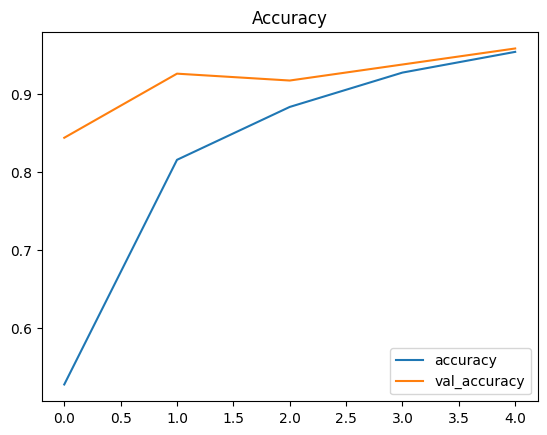

In [ ]:
# Chuyển đổi lịch sử huấn luyện thành DataFrame
# Vẽ đồ thị so sánh độ chính xác trên tập huấn luyện (accuracy) và tập xác thực (val_accuracy) theo từng epoch
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

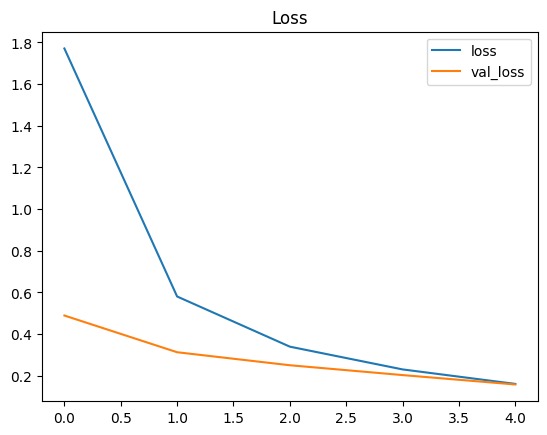

In [ ]:
# Tương tự như trên, nhưng vẽ đồ thị so sánh hàm mất mát trên tập huấn luyện (loss) và tập xác thực (val_loss) theo từng epoch
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

#### 4. Trực quan hóa kết quả<a class="anchor" id="4"></a>

In [ ]:
# Dự đoán nhãn cho tập kiểm tra
pred = model.predict(test_images)
# Chọn nhãn có xác suất cao nhất từ kết quả dự đoán
pred = np.argmax(pred,axis=1)

# Lấy từ trình tạo dữ liệu huấn luyện, ánh xạ nhãn số sang tên nhãn
labels = (train_images.class_indices)
# Đảo ngược từ điển để ánh xạ từ số sang tên nhãn
labels = dict((v,k) for k,v in labels.items())
# Chuyển đổi nhãn dự đoán và nhãn thực tế từ số sang tên
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


In [ ]:
# Tính toán và in ra độ chính xác của mô hình trên tập kiểm tra bằng cách so sánh nhãn thực (y_test) và nhãn dự đoán (pred) sử dụng accuracy_score từ sklearn.metrics
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 95.88%


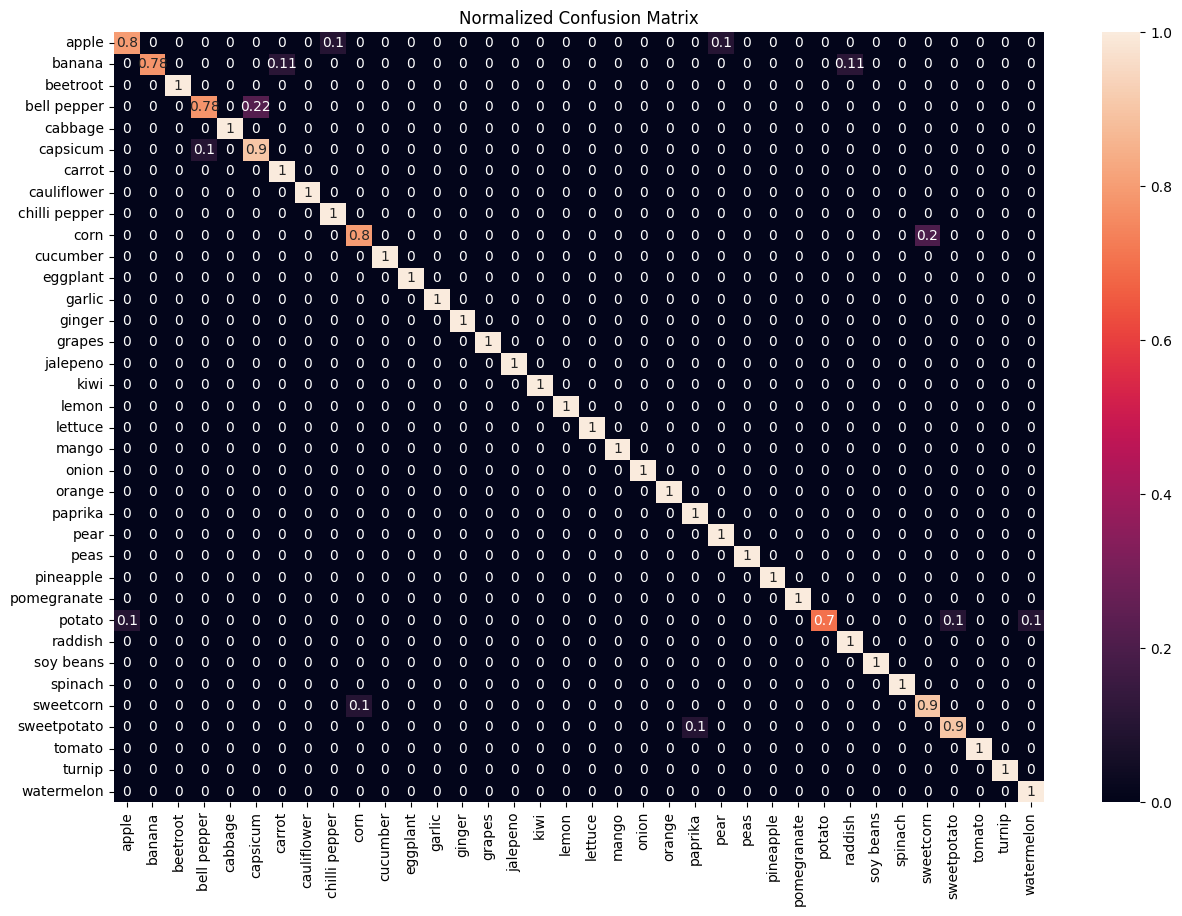

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Tạo ma trận hỗn loạn giữa nhãn thực và nhãn dự đoán, với normalize='true' để tỷ lệ hóa theo hàng
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
# Trực quan hóa ma trận hỗn loạn dưới dạng bản đồ nhiệt (heatmap) với phép chú thích (annot=True)
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

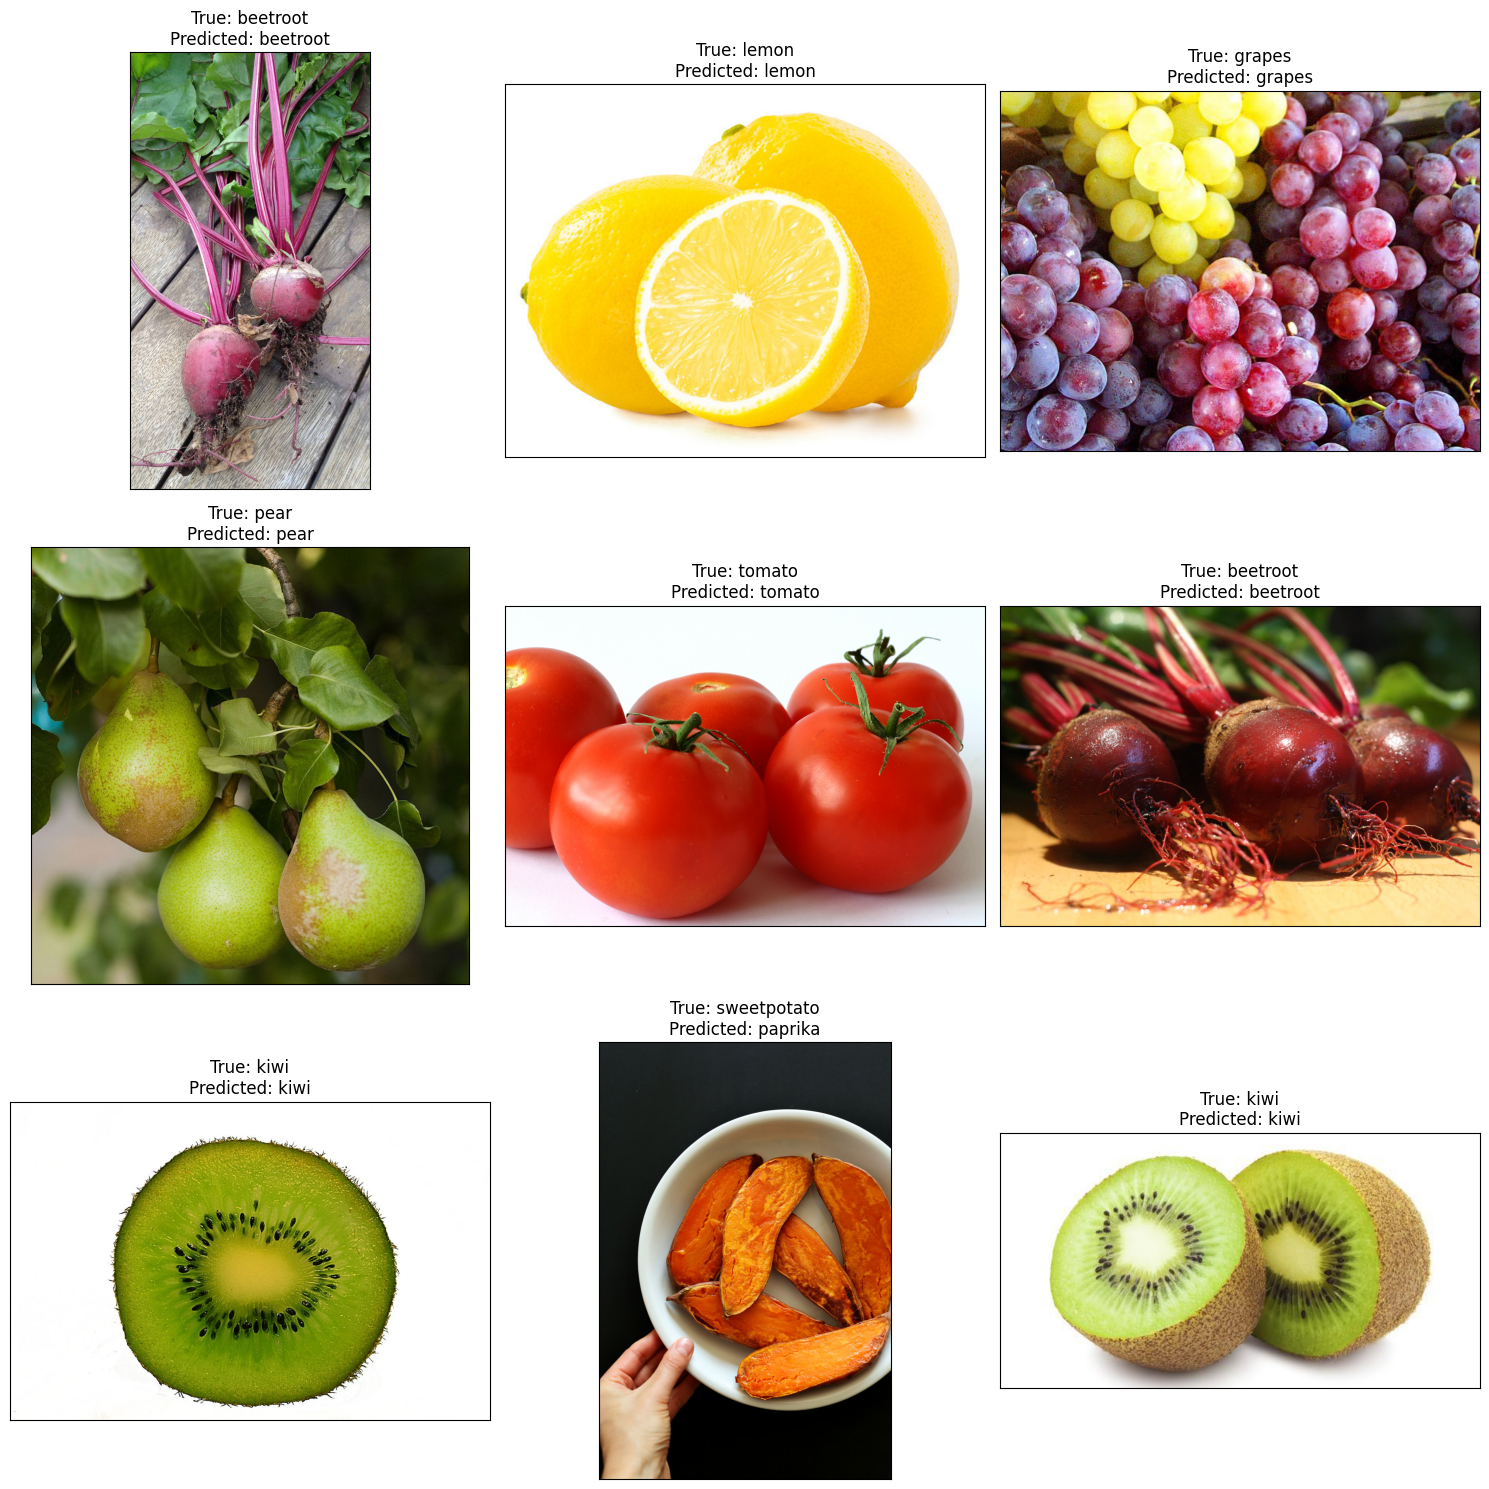

In [ ]:
# Chọn ngẫu nhiên 9 hình ảnh từ tập kiểm tra
num_images = 9
random_indices = np.random.choice(len(test_df), num_images, replace=False)

# Tạo một lưới 3x3 để hiển thị các hình ảnh đó
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

# Đọc và hiển thị hình ảnh từ đường dẫn, đặt tiêu đề bao gồm nhãn thực và nhãn dự đoán
for i, ax in enumerate(axes.flat):
    idx = random_indices[i]
    ax.imshow(plt.imread(test_df.Filepath.iloc[idx]))
    ax.set_title(f"True: {test_df.Label.iloc[idx]}\nPredicted: {pred[idx]}")
# Sử dụng tight_layout để điều chỉnh khoảng cách giữa các subplot và hiển thị hình ảnh
plt.tight_layout()
plt.show()